In [1]:
!pip install deap yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 3.5 MB/s eta 0:00:00


In [2]:
!pip install deap

In [9]:
import os
import glob
import pandas as pd
import numpy as np
from deap import base, creator, tools, algorithms

# 기술적 지표 함수 정의
def SMA(series, window): return series.rolling(window).mean()
def EMA(series, span): return series.ewm(span=span, adjust=False).mean()
def RSI(series, window):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.rolling(window).mean()
    ma_down = down.rolling(window).mean()
    rs = ma_up / ma_down
    return 100 - (100 / (1 + rs))
def ROC(series, window):
    return series.pct_change(periods=window) * 100
def MACD(series, fast, slow, signal):
    ema_fast = EMA(series, fast)
    ema_slow = EMA(series, slow)
    macd_line = ema_fast - ema_slow
    macd_signal = EMA(macd_line, signal)
    return macd_line, macd_signal
def BBANDS(series, window, n_std):
    ma = SMA(series, window)
    std = series.rolling(window).std()
    upper = ma + n_std * std
    lower = ma - n_std * std
    return upper, lower

# 시그널 생성
def signal_sma(close, window):
    ma = SMA(close, window)
    return np.where(close > ma, -1, 1)

def signal_ema(close, span):
    ema = EMA(close, span)
    return np.where(close > ema, -1, 1)

def signal_rsi(close, window, lo=30, hi=70):
    rsi = RSI(close, window)
    sig = np.zeros(len(rsi))
    sig[rsi < lo] = -1
    sig[rsi > hi] = 1
    return sig

def signal_roc(close, window):
    roc = ROC(close, window)
    sig = np.zeros(len(roc))
    sig[roc > 0] = -1
    sig[roc < 0] = 1
    return sig

def signal_macd(close, fast, slow, signal):
    macd_line, macd_sig = MACD(close, fast, slow, signal)
    cross = macd_line - macd_sig
    sig = np.zeros(len(close))
    sig[(cross.shift(1) < 0) & (cross > 0)] = -1
    sig[(cross.shift(1) > 0) & (cross < 0)] = 1
    return sig

def signal_bb(close, window, n_std):
    upper, lower = BBANDS(close, window, n_std)
    sig = np.zeros(len(close))
    sig[close < lower] = -1
    sig[close > upper] = 1
    return sig

# 기술적 지표 설정
INDICATORS = {
    'sma':  {'func': signal_sma,  'bounds': [(5, 50)],               'size': 1},
    'ema':  {'func': signal_ema,  'bounds': [(5, 50)],               'size': 1},
    'rsi':  {'func': signal_rsi,  'bounds': [(5, 30), (20, 80)],     'size': 2},
    'roc':  {'func': signal_roc,  'bounds': [(5, 30)],               'size': 1},
    'macd': {'func': signal_macd, 'bounds': [(5, 20), (20, 100), (5, 20)], 'size': 3},
    'bb':   {'func': signal_bb,   'bounds': [(10, 50), (1, 3)],      'size': 2},
}

# 평가 함수
def compute_performance(returns, freq=252):
    cum_return = (1 + returns).cumprod()
    ann_ret = (cum_return.iloc[-1]) ** (freq / len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(freq)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else -10.0
    drawdown = cum_return / cum_return.cummax() - 1
    mdd = drawdown.min()
    return sharpe, mdd

# GA 평가 함수
def evaluate(individual, df, train_ix):
    sig_total = np.zeros(len(df))
    idx = 0
    selected = 0

    for name, conf in INDICATORS.items():
        use_it = individual[idx]
        idx += 1
        if use_it:
            params = [int(individual[idx + i]) for i in range(conf['size'])]
            try:
                sig = conf['func'](df['Close'], *params)
                sig = pd.Series(sig, index=df.index).shift(1).fillna(0)
                sig_total += sig
                selected += 1
            except:
                return -10.0,
            idx += conf['size']
        else:
            idx += conf['size']

    if selected == 0:
        return -10.0,

    sig_avg = np.sign(sig_total / selected)
    ret = df['Close'].pct_change().fillna(0)
    strat_ret = sig_avg[train_ix] * ret[train_ix]
    sharpe, _ = compute_performance(strat_ret)
    return sharpe,

# 최적화
def optimize_combination(df, train_ix, ngen=30, pop=50):
    # creator 중복 생성 방지
    if 'FitnessMax' in creator.__dict__:
        del creator.FitnessMax
    if 'Individual' in creator.__dict__:
        del creator.Individual

    # DEAP 설정
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    toolbox = base.Toolbox()

    # 각 인디케이터의 on/off + 파라미터를 genome으로 구성
    indicator_names = list(INDICATORS.keys())
    indicator_bounds = [INDICATORS[k]['bounds'] for k in indicator_names]

    genome = []
    for bounds in indicator_bounds:
        genome.append([(0, 1)])  # on/off gene
        genome.extend([bounds])

    # 평탄화
    flat_bounds = []
    for b in genome:
        flat_bounds.extend(b)

    # gene 생성기 등록
    def create_gene(bounds):
        return np.random.randint(bounds[0], bounds[1]+1)

    for i, b in enumerate(flat_bounds):
        toolbox.register(f"gene_{i}", create_gene, b)

    # 유전자 개체 등록
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     [toolbox.__getattribute__(f"gene_{i}") for i in range(len(flat_bounds))], n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # 평가함수 등록 (evaluate()는 별도로 구현 필요)
    toolbox.register("evaluate", evaluate, df=df, train_ix=train_ix)

    # 유전 알고리즘 연산자 등록
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutUniformInt,
                     low=[b[0] for b in flat_bounds],
                     up=[b[1] for b in flat_bounds],
                     indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # 실행
    pop = toolbox.population(n=pop)
    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=ngen, verbose=False)

    # 최적 개체 반환
    best = tools.selBest(pop, k=1)[0]
    return best

# 메인 실행
if __name__ == "__main__":
    data_dir = '/content/drive/MyDrive/시계열/data/preprocessed'
    files = glob.glob(os.path.join(data_dir, '*_processed.csv'))

    for fp in files:
        ticker = os.path.basename(fp).split('_')[0]
        df = pd.read_csv(fp, parse_dates=['Date'], index_col='Date')
        split = int(len(df)*0.7)
        train_ix = df.index[:split]
        test_ix = df.index[split:]

        print(f"\n=== {ticker} 최적화 중 ===")
        best = optimize_combination(df, train_ix)

        # 결과 확인
        idx = 0
        for name, conf in INDICATORS.items():
            use_it = best[idx]
            idx += 1
            if use_it:
                params = [int(best[idx + i]) for i in range(conf['size'])]
                print(f"지표 {name} 사용 (params={params})")
            idx += conf['size']



=== NVDA 최적화 중 ===


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnu

ValueError: span must satisfy: span >= 1

In [16]:
import os
import glob
import pandas as pd
import numpy as np
from deap import base, creator, tools, algorithms

# --- 기술적 지표 함수 정의 ---
def SMA(series, window): return series.rolling(window).mean()
def EMA(series, span):
    if span < 1:  # 안전장치
        span = 1
    return series.ewm(span=span, adjust=False).mean()
def RSI(series, window):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.rolling(window).mean()
    ma_down = down.rolling(window).mean()
    rs = ma_up / ma_down
    return 100 - (100 / (1 + rs))
def ROC(series, window): return series.pct_change(periods=window) * 100
def MACD(series, fast, slow, signal):
    fast = max(1, fast)
    slow = max(1, slow)
    signal = max(1, signal)
    ema_fast = EMA(series, fast)
    ema_slow = EMA(series, slow)
    macd_line = ema_fast - ema_slow
    macd_signal = EMA(macd_line, signal)
    return macd_line, macd_signal
def BBANDS(series, window, n_std):
    ma = SMA(series, window)
    std = series.rolling(window).std()
    upper = ma + n_std * std
    lower = ma - n_std * std
    return upper, lower

# --- 시그널 생성 함수 ---
def signal_sma(close, window): return np.where(close > SMA(close, window), -1, 1)
def signal_ema(close, span): return np.where(close > EMA(close, span), -1, 1)
def signal_rsi(close, window, lo=30, hi=70):
    rsi = RSI(close, window)
    sig = np.zeros(len(rsi))
    sig[rsi < lo] = -1
    sig[rsi > hi] = 1
    return sig
def signal_roc(close, window):
    roc = ROC(close, window)
    sig = np.zeros(len(roc))
    sig[roc > 0] = -1
    sig[roc < 0] = 1
    return sig
def signal_macd(close, fast, slow, signal):
    macd_line, macd_sig = MACD(close, fast, slow, signal)
    cross = macd_line - macd_sig
    sig = np.zeros(len(close))
    sig[(cross.shift(1) < 0) & (cross > 0)] = -1
    sig[(cross.shift(1) > 0) & (cross < 0)] = 1
    return sig
def signal_bb(close, window, n_std):
    upper, lower = BBANDS(close, window, n_std)
    sig = np.zeros(len(close))
    sig[close < lower] = -1
    sig[close > upper] = 1
    return sig

# --- 기술적 지표 정의 ---
INDICATORS = {
    'sma':  {'func': signal_sma,  'bounds': [(5, 50)],               'size': 1},
    'ema':  {'func': signal_ema,  'bounds': [(5, 50)],               'size': 1},
    'rsi':  {'func': signal_rsi,  'bounds': [(5, 30), (20, 80)],     'size': 2},
    'roc':  {'func': signal_roc,  'bounds': [(5, 30)],               'size': 1},
    'macd': {'func': signal_macd, 'bounds': [(5, 20), (20, 100), (5, 20)], 'size': 3},
    'bb':   {'func': signal_bb,   'bounds': [(10, 50), (1, 3)],      'size': 2},
}

# --- 평가 함수 ---
def compute_performance(returns, freq=252):
    cum_return = (1 + returns).cumprod()
    ann_ret = cum_return.iloc[-1] ** (freq / len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(freq)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else -10.0
    drawdown = cum_return / cum_return.cummax() - 1
    mdd = drawdown.min()
    return sharpe, mdd

# --- 평가 함수 for GA ---
def evaluate(individual, df, train_ix):
    sig_total = np.zeros(len(df))
    idx = 0
    selected = 0
    for name, conf in INDICATORS.items():
        use_it = individual[idx]
        idx += 1
        if use_it:
            params = [int(individual[idx + i]) for i in range(conf['size'])]
            # 최소값 1 이상 보장
            params = [max(1, p) for p in params]
            try:
                sig = conf['func'](df['Close'], *params)
                sig = pd.Series(sig, index=df.index).shift(1).fillna(0)
                sig_total += sig
                selected += 1
            except Exception as e:
                print(f"Error in indicator {name} with params {params}: {e}")
                return -10.0,
            idx += conf['size']
        else:
            idx += conf['size']
    if selected == 0:
        return -10.0,
    sig_avg = np.sign(sig_total / selected)
    ret = df['Close'].pct_change().fillna(0)
    strat_ret = sig_avg[train_ix] * ret[train_ix]
    sharpe, _ = compute_performance(strat_ret)
    return sharpe,

# --- 최적화 함수 ---
def optimize_combination(df, train_ix, ngen=30, pop=50):
    # 삭제 시도 (이미 생성되었을 경우)
    if 'FitnessMax' in creator.__dict__:
        del creator.FitnessMax
    if 'Individual' in creator.__dict__:
        del creator.Individual

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    toolbox = base.Toolbox()

    # use_it gene (0 or 1) 리스트 생성
    use_it_bounds = [(0,1)] * len(INDICATORS)
    # 파라미터 gene bounds 리스트 생성 (flatten)
    param_bounds = []
    for conf in INDICATORS.values():
        param_bounds.extend(conf['bounds'])

    # gene 생성기 등록
    def create_use_it():
        return np.random.randint(0, 2)  # 0 or 1

    def create_param(low, up):
        return np.random.randint(low, up+1)

    # use_it genes
    for i in range(len(use_it_bounds)):
        toolbox.register(f"use_it_gene_{i}", create_use_it)
    # param genes
    for i, (low, up) in enumerate(param_bounds):
        toolbox.register(f"param_gene_{i}", create_param, low, up)

    # individual 생성기: use_it genes + param genes 합치기
    def create_individual():
        genes = []
        # use_it genes
        for i in range(len(use_it_bounds)):
            genes.append(toolbox.__getattribute__(f"use_it_gene_{i}")())
        # param genes
        for i in range(len(param_bounds)):
            genes.append(toolbox.__getattribute__(f"param_gene_{i}")())
        return creator.Individual(genes)

    toolbox.register("individual", create_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evaluate, df=df, train_ix=train_ix)
    toolbox.register("mate", tools.cxTwoPoint)

    # mutate : use_it genes와 param genes 분리 적용
    def mutate_individual(individual):
        # use_it genes (첫 N개)
        for i in range(len(use_it_bounds)):
            if np.random.rand() < 0.2:
                individual[i] = 1 - individual[i]  # 0 <-> 1 토글

        # param genes
        offset = len(use_it_bounds)
        for i, (low, up) in enumerate(param_bounds):
            if np.random.rand() < 0.2:
                individual[offset + i] = np.random.randint(low, up + 1)
        return individual,

    toolbox.register("mutate", mutate_individual)
    toolbox.register("select", tools.selTournament, tournsize=3)

    pop = toolbox.population(n=pop)
    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=ngen, verbose=False)

    return tools.selBest(pop, k=1)[0]

# --- 경험적 파라미터 설정 ---
EMPIRICAL_PARAMS = {
    'sma': [20],
    'ema': [20],
    'rsi': [14, 30],
    'roc': [14],
    'macd': [12, 26, 9],
    'bb': [20, 2]
}

# --- 결과 저장용 리스트 ---
results = []

# --- 메인 실행 ---
if __name__ == "__main__":
    data_dir = '/content/drive/MyDrive/시계열/data/preprocessed'
    files = glob.glob(os.path.join(data_dir, '*_processed.csv'))

    for fp in files:
        ticker = os.path.basename(fp).split('_')[0]
        df = pd.read_csv(fp, parse_dates=['Date'], index_col='Date')
        split = int(len(df)*0.7)
        train_ix = df.index[:split]
        test_ix = df.index[split:]

        print(f"\n=== {ticker} 최적화 중 ===")
        best = optimize_combination(df, train_ix)

        signal_opt, signal_emp = np.zeros(len(df)), np.zeros(len(df))
        idx = 0

        for name, conf in INDICATORS.items():
            use_it = best[idx]
            idx += 1
            if use_it:
                params = [int(best[idx + i]) for i in range(conf['size'])]
                params = [max(1, p) for p in params]  # 최소 1 보장
                sig = conf['func'](df['Close'], *params)
                signal_opt += pd.Series(sig, index=df.index).shift(1).fillna(0)

                emp_params = EMPIRICAL_PARAMS[name]
                sig_emp = conf['func'](df['Close'], *emp_params)
                signal_emp += pd.Series(sig_emp, index=df.index).shift(1).fillna(0)

                results.append({
                    'Ticker': ticker,
                    'Indicator': name,
                    'Use': 1,
                    'Params_Opt': str(params),
                    'Params_Emp': str(emp_params)
                })
            else:
                idx += conf['size']
                results.append({
                    'Ticker': ticker,
                    'Indicator': name,
                    'Use': 0,
                    'Params_Opt': '',
                    'Params_Emp': str(EMPIRICAL_PARAMS[name])
                })

        # 전략 수익률 계산
        ret = df['Close'].pct_change().fillna(0)
        # signal_opt에서 0이 아닌 값 개수 세기 (지표별 합산이기 때문에 0이 아닐 때 평균)
        nonzero_count_opt = np.count_nonzero(signal_opt)
        nonzero_count_emp = np.count_nonzero(signal_emp)

        sig_avg_opt = np.sign(signal_opt / max(1, nonzero_count_opt))
        sig_avg_emp = np.sign(signal_emp / max(1, nonzero_count_emp))

        strat_ret_opt = sig_avg_opt[test_ix] * ret[test_ix]
        strat_ret_emp = sig_avg_emp[test_ix] * ret[test_ix]

        sharpe_opt, mdd_opt = compute_performance(strat_ret_opt)
        sharpe_emp, mdd_emp = compute_performance(strat_ret_emp)

        # 종합 결과
        for r in results:
            if r['Ticker'] == ticker:
                r.update({
                    'Sharpe_Opt': sharpe_opt,
                    'Sharpe_Emp': sharpe_emp,
                    'MDD_Opt': mdd_opt,
                    'MDD_Emp': mdd_emp,
                    'Sharpe_Improved': sharpe_opt > sharpe_emp,
                    'MDD_Improved': mdd_opt > mdd_emp
                })

    # CSV 저장
    df_result = pd.DataFrame(results)
    df_result.to_csv("/content/drive/MyDrive/시계열/reports/optimization_results.csv", index=False)
    print("\n[✅ 완료] 결과가 'optimization_results.csv'로 저장되었습니다.")



=== NVDA 최적화 중 ===


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnu


=== TSLA 최적화 중 ===


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnu


=== MSFT 최적화 중 ===


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
<ipython-input-16-c6cf08ade65a>:80: RuntimeWarning: invalid value encountered in scalar power
  ann_ret = cum_return.iloc[-1] ** (freq / len(returns)) - 1
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
<ipython-input-16-c6cf08ade65a>:80: RuntimeWarning: invalid 


=== AAPL 최적화 중 ===


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnu


=== BRK-B 최적화 중 ===


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
<ipython-input-16-c6cf08ade65a>:80: RuntimeWarning: invalid value encountered in scalar power
  ann_ret = cum_return.iloc[-1] ** (freq / len(returns)) - 1
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnume


=== AMZN 최적화 중 ===


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnu


=== META 최적화 중 ===


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnu


=== JNJ 최적화 중 ===


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnu


=== GOOGL 최적화 중 ===


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnu


=== UNH 최적화 중 ===


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnu


[✅ 완료] 결과가 'optimization_results.csv'로 저장되었습니다.


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


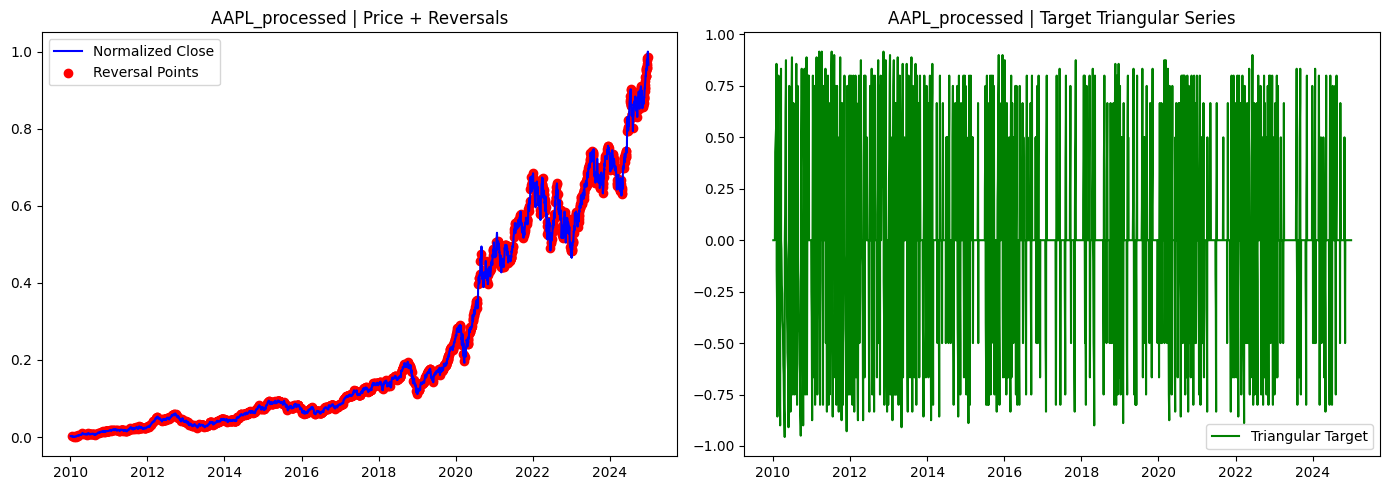

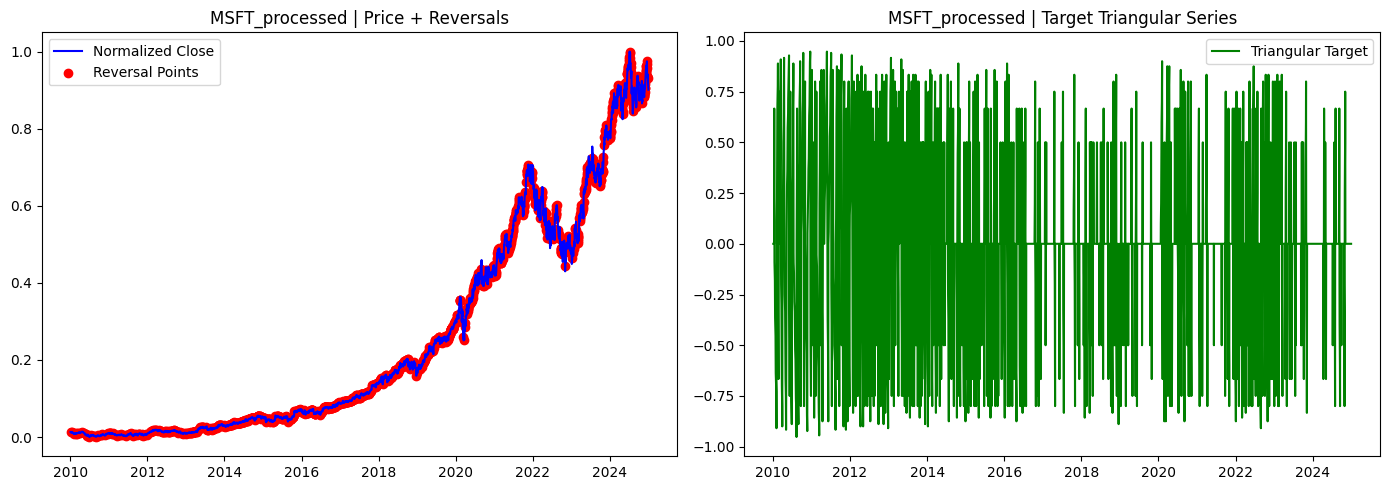

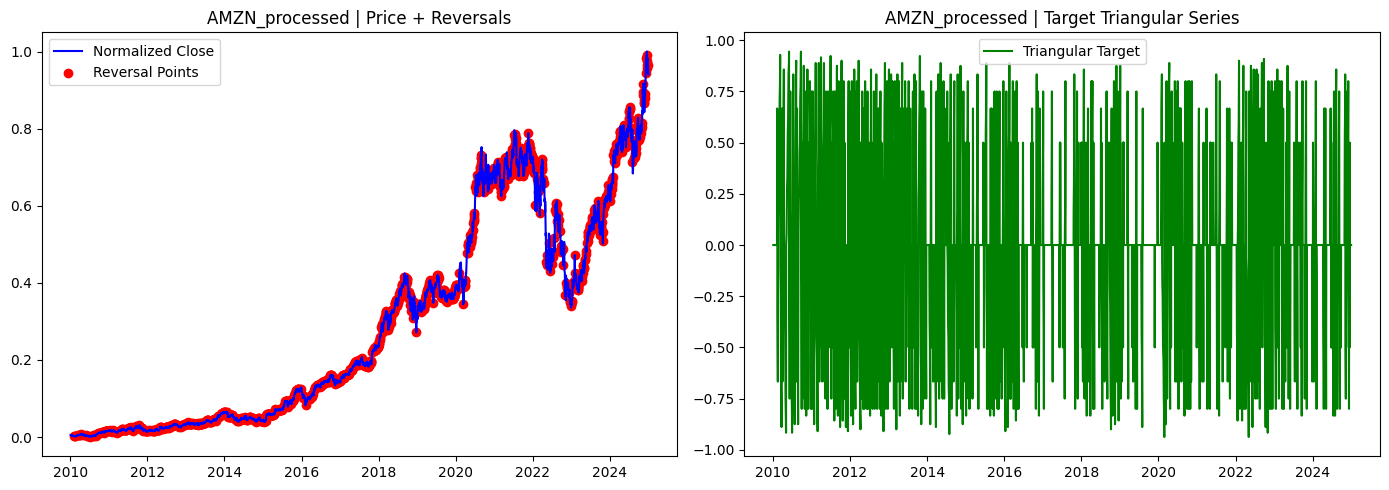

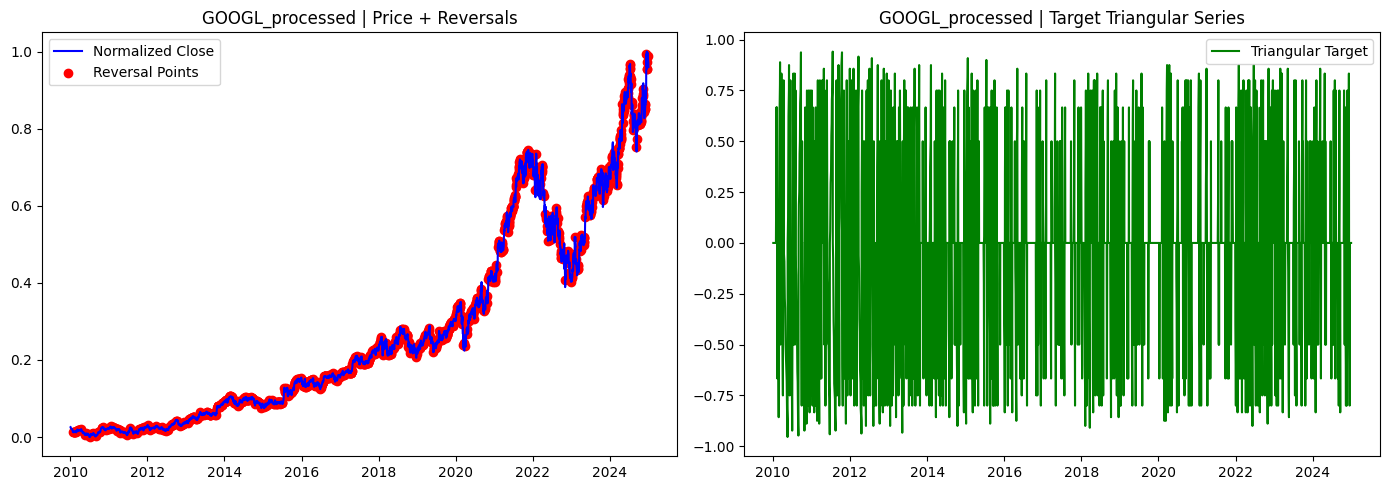

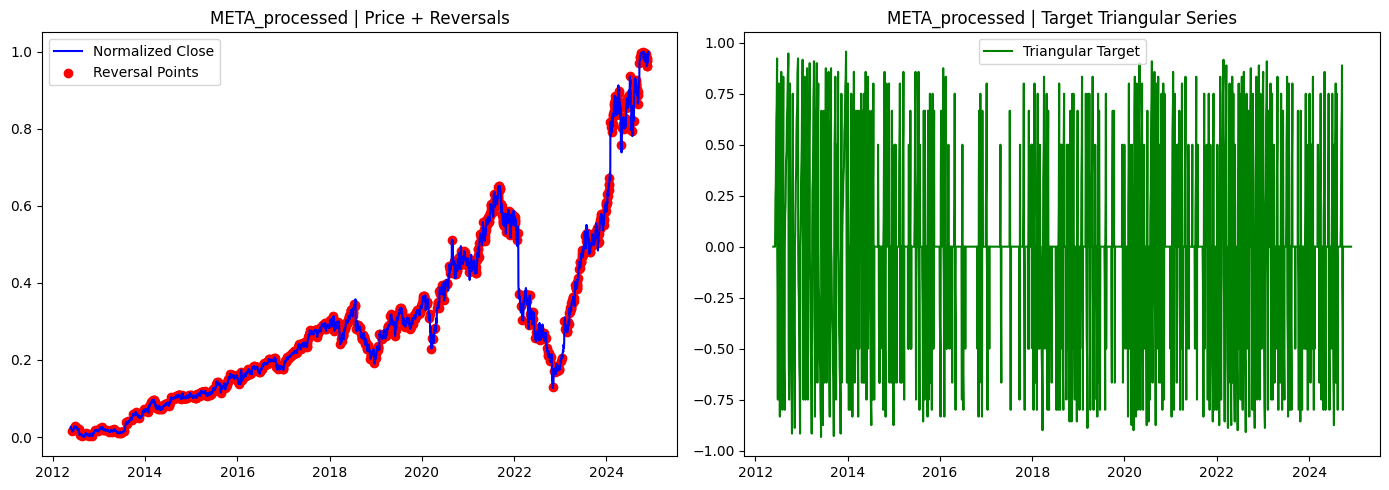

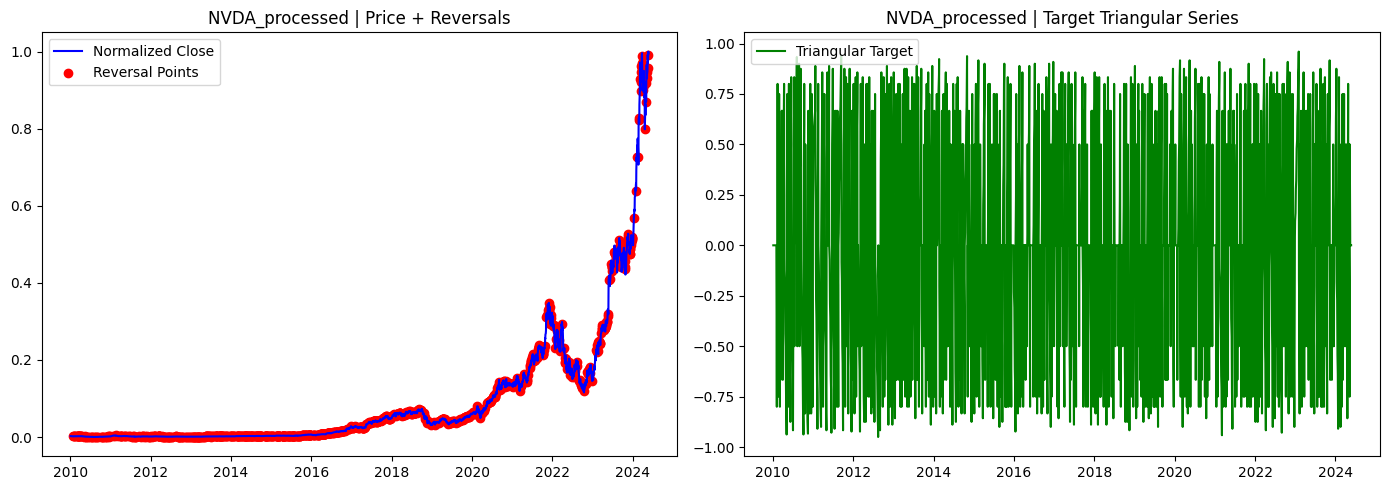

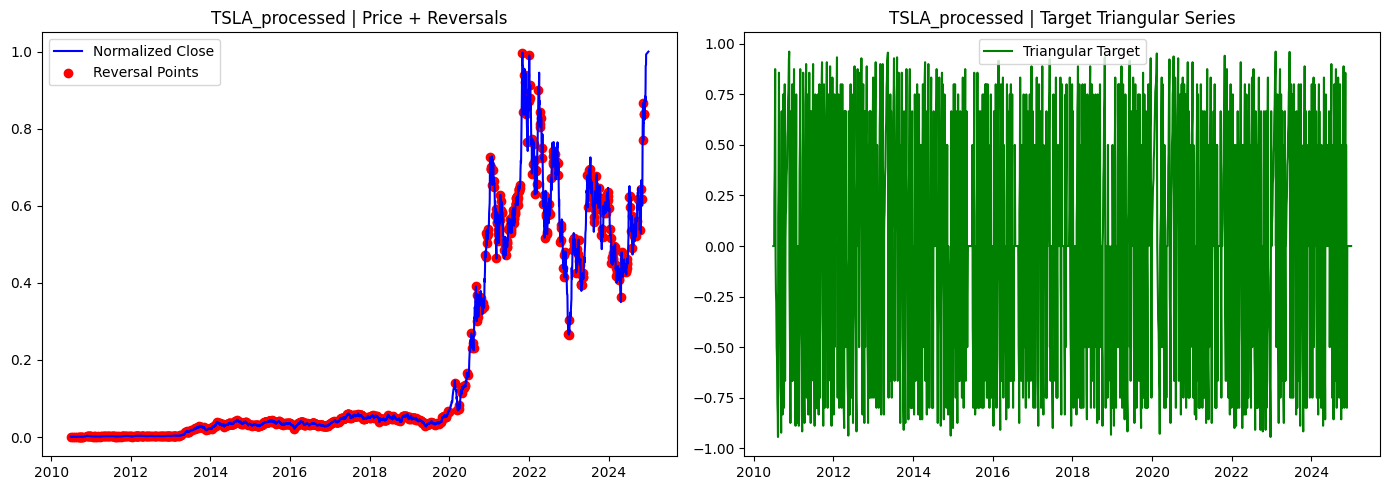

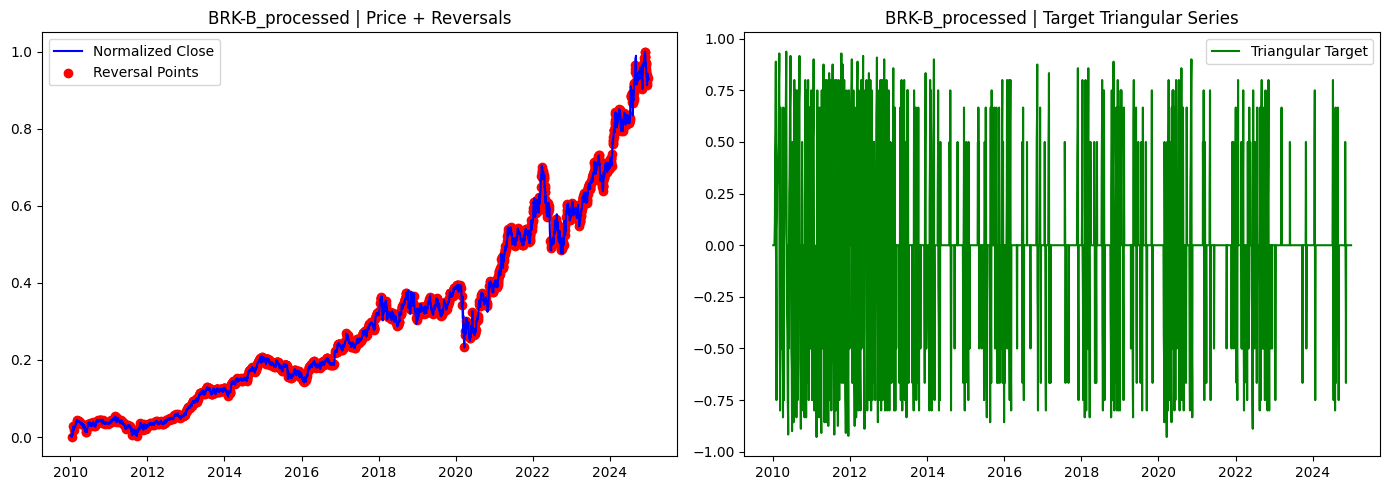

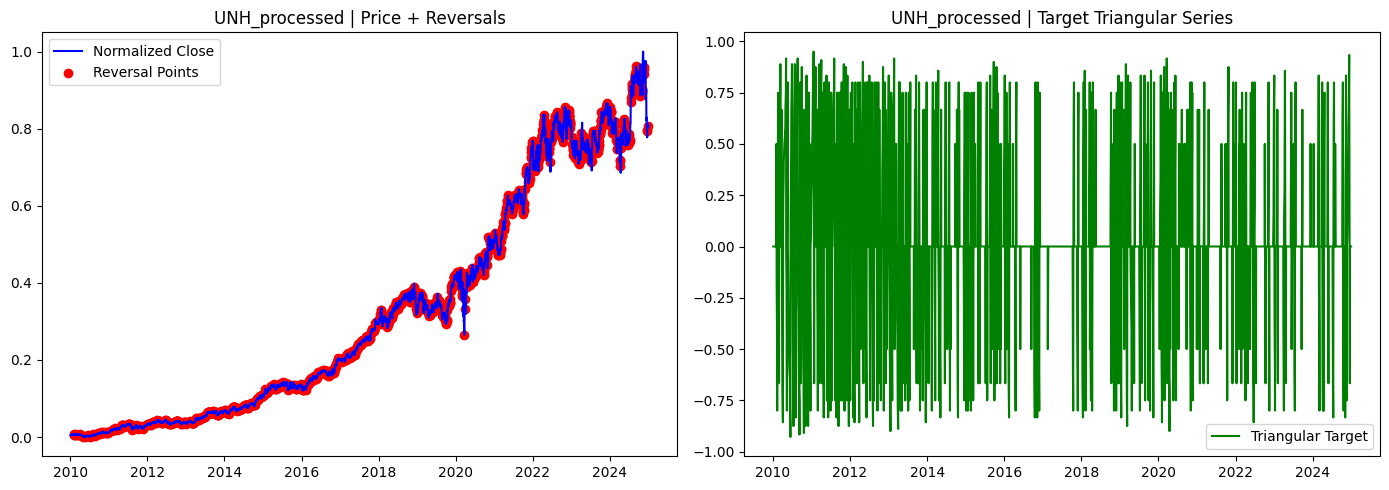

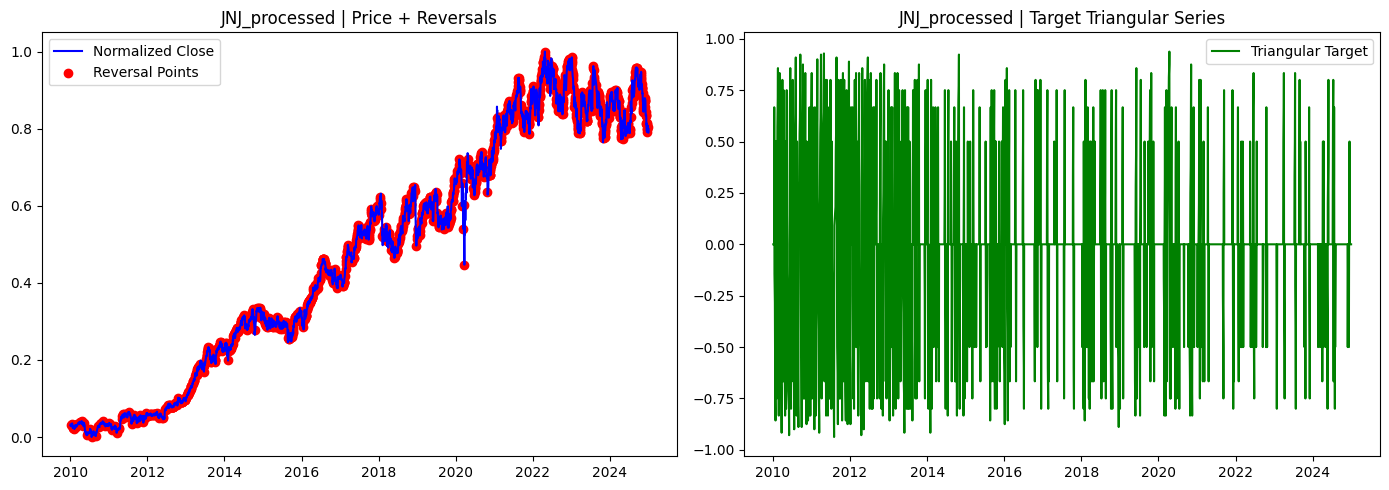

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 리버설 포인트 찾기
def find_reversal_points(prices, P=0.05, T=5):
    n = len(prices)
    extrema_idx = []
    direction = 0  # 1: 상승 중, -1: 하락 중

    for i in range(T, n - T):
        window = prices[i - T:i + T + 1]
        center = prices[i]
        max_p = np.max(window)
        min_p = np.min(window)

        if direction <= 0 and center >= max_p * (1 - P):
            extrema_idx.append(i)
            direction = 1
        elif direction >= 0 and center <= min_p * (1 + P):
            extrema_idx.append(i)
            direction = -1

    return extrema_idx

# 삼각파 타겟 생성
def get_triangular_target(length, extrema_idx):
    target = np.zeros(length)
    for i in range(1, len(extrema_idx)):
        start, end = extrema_idx[i - 1], extrema_idx[i]
        sign = 1 if i % 2 == 1 else -1
        slope = sign * 1.0 / (end - start)
        for j in range(start, end):
            target[j] = slope * (j - start)
    return target

# 최적의 ΔP를 찾는 함수
def find_optimal_P(prices, T=5, min_points=15, max_points=60, step=0.01):
    best_P = None
    best_count = 0
    for P in np.arange(0.01, 0.11, step):
        extrema_idx = find_reversal_points(prices, P, T)
        count = len(extrema_idx)
        if min_points <= count <= max_points:
            best_P = P
            best_count = count
    return best_P if best_P else 0.05  # fallback

# 전체 타겟 생성 함수
def generate_all_targets(processed_dir, target_dir, T=5, min_points=15, max_points=60):
    os.makedirs(target_dir, exist_ok=True)
    for file in os.listdir(processed_dir):
        if not file.endswith('.csv'):
            continue

        ticker = file.replace('.csv', '')
        df = pd.read_csv(os.path.join(processed_dir, file), parse_dates=['Date'])
        df.sort_values('Date', inplace=True)
        df.reset_index(drop=True, inplace=True)

        prices = df['Close'].values
        best_P = find_optimal_P(prices, T=T, min_points=min_points, max_points=max_points)
        extrema_idx = find_reversal_points(prices, best_P, T)
        target = get_triangular_target(len(prices), extrema_idx)
        df['triangular_target'] = target

        df.to_csv(os.path.join(target_dir, f'{ticker}.csv'), index=False)

        # 시각화
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.plot(df['Date'], (df['Close'] - df['Close'].min()) / (df['Close'].max() - df['Close'].min()), 'b', label='Normalized Close')
        plt.scatter(df['Date'].iloc[extrema_idx], df['Close'].iloc[extrema_idx], c='r', label='Reversal Points')
        plt.title(f'{ticker} | Price + Reversals')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(df['Date'], target, 'g', label='Triangular Target')
        plt.title(f'{ticker} | Target Triangular Series')
        plt.legend()
        plt.tight_layout()
        plt.show()


processed_dir = '/content/drive/MyDrive/시계열/data/preprocessed'
target_dir = '/content/drive/MyDrive/시계열/data/target'

generate_all_targets(processed_dir, target_dir)
